In [1]:
from IPython.display import HTML
import warnings
#warnings.filterwarnings('ignore')
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
from ipywidgets import interact
import numpy as np
import pandas as pd
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
import numpy as np
import mpmath as mp
import copy 
from matplotlib import pyplot as plt
from scipy.integrate import quad 
from scipy.optimize import minimize
import re

output_notebook()
%matplotlib inline



Loading BokehJS ...

In [3]:
def write_to_summary(line_pattern,value):
    lines = []
    rline_pat = re.compile('^'+line_pattern+".*")
    with open("./results.table.tsv",'r') as results:
        for line in results:
            if rline_pat.match(line):
                line = line_pattern +"\t" + str(value)+"\n"
            lines.append(line)
            
    with open("./results.table.tsv",'w') as output:
        for l in lines:
            output.write(l)

## Reading in the accuracy table

In [4]:
acc_stringent = pd.read_csv("../data/reference/accuracy_stringent.csv")

acc_stringent

,Unnamed: 0,exp.freq,freq,TP,sensitivity,FP,gc_ul,PPV
0,1,0.05,0.05,17,0.85,0,100000.0,1.000000
1,2,0.02,0.02,3,0.15,0,100000.0,1.000000
2,3,0.05,0.05,17,0.85,0,10000.0,1.000000
3,4,0.02,0.02,3,0.15,0,10000.0,1.000000
4,5,0.05,0.05,14,0.70,0,1000.0,1.000000
5,6,0.02,0.02,3,0.15,0,1000.0,1.000000
6,7,0.01,0.01,1,0.05,2,1000.0,0.333333


 ## Equation set up
 
 Let p(p,x,t,N) be the time dependent probability of a variant at x after t generations when the initial frequency was p, and the effective population size is N.
 
 From Kimura 1955 we have,
 
 $$
p(p,x,t,N) = \sum_{i=1}^{\infty}pqi(i+1)(2i+1)F(1-i,i+2,2,p) \times F(1-i,i+2,2,x) e^{-[i(i+1)/2N]t}
$$

Where $q=1-p$ and $F$ is the hypergeometric function.
 
The code is below.

In [5]:
def ith_term(i,p,t,x,N): # proofed JT 5/22/17
    q=1-p
    first = p*q*i*(i+1)*((2*i)+1)    
    geometric_1= mp.hyp2f1(1-i,i+2,2,p,zeroprec=10) # verify this the correct function (it's the only hypergeometric I could find with 4 variables) - This is correct 
    geometric_2= mp.hyp2f1(1-i,i+2,2,x,zeroprec = 10)
    exponent= i*(i+1)*t/(2*N) # 4N in the book
    out=first*geometric_1*geometric_2*np.exp(-1*exponent)
    return(float(out))

def non_fixed(p,x,t,N,sensitivity=False,*args,**kwargs):
    gc_ul = kwargs.get('gc_ul', None) # If these  variables are supplied get them. They are used to account for sensitivity. sensivity must be set to True
    acc = kwargs.get('acc', None)
    ith=[ith_term(i=1,p=p,x=x,t=t,N=N),ith_term(i=2,p=p,x=x,t=t,N=N)] # The first 2 terms are done to begin
    i = 3
#    while (ith[i-3]-ith[i-2])>1e-5: # Continue until the difference between the last 2 terms is less than 1e-5
#    while ith[i-2]>1e-3: 
    while i<=50:
        ith.append(ith_term(i=i,p=p,x=x,t=t,N=N))
        i+=1
    #print(ith)
    perfect_detect = np.sum(ith)


    if sensitivity == False :
        return(perfect_detect)
    
    else:# this is the probability of the variant being found where it was given the sensitivity. 
            # This is not used in the fitting of the model. All of these variants are found. For each N that we try this term doesn't change. So it is a constant not dependent on N and so doesn't affect the estimate.
            # It is useful though in getting a pdf that sums to 1 in the plots. If we don't have perfect sensitivity for the lost variants then we should treat these the same.
        acc_gc=10**(np.floor(np.log10(gc_ul))) # round down to the nearest log10 
        if acc_gc>1e5: # set for the max. We assume we do not gain sensitivity above this cut off. We probably do, but we don't have data on it so this is more conservative
            acc_gc=1e5

        ## Here we assume the accuracy of each range is the same as the smaller range
        if x<0.05 and x>0.02:
            sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==0.02),'sensitivity']
            sense = sense.iloc[0]
            prob_detect = perfect_detect*sense
        elif x<0.1 and x>0.05:
            sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==0.05),'sensitivity']
            sense = sense.iloc[0]
            prob_detect = perfect_detect*sense
        else :
            prob_detect = perfect_detect # We assume perfect detection above 10%

        return(prob_detect) 


The time depenent probabilty of a variant being lost  or not observed at generation t is given by the sum of the probabity that it is lost by generation t p(p,0,t,N) and the probability that it is not detected due to the limit of detection or low sensitivity to detect rare variants P(below_cut)+P(p,x,t,N)\*P(not_detected,x). 

p(not_detect) = P(other_allele_fixed)+p(below_threshold)+p(present_but_overlooked)


Variants that are fixed (there are non in the data set but its good to handel anyway)

p(other_allele_not_detected) = p(fixed)+p(other_below_theshold)+p(other_present_but_overlooked)

 
$$
p(p,0,t,N) = q +\sum_{i=1}^{\infty}(2i+1)pq(-1)^i F(1-i,i+2,2,q) e^{-[i(i+1)/2N]t}
$$
 
Where q is defined as above. (Note : this is simply the probability of fixation for a variant at initial frequency q.
$$
P(\text{below_cut}) = \int_0^{0.02} p(p,x,t,N)dx
$$
 
Note the limit of detection is 0.02.
 
$$
P(\text{present_but_not_detected}) = \sum_{f_e}^{[0.02,0.05,0.10)} \big(\text{FNR}|\text{Titer}_r,f_e) \int_{f_e}^{f_e+1} p(p,x,t,N)dx
$$
 
Where $(\text{FNR}|\text{Titer}_r,f_e)$ is the false negative rate given the frequency and the sample titer.

In [6]:
def ith_term_fixed(i,p,t,N):# proofed JT 5/22/17
    first = (2*i+1)*p*(1-p)*(-1)**i
    geometric = mp.hyp2f1(1-i,i+2,2,p,zeroprec=10)
    exponent= i*(i+1)*t/(2*N) # 4N in the book
    out = first*geometric*np.exp(-1*exponent)
    return(float(out))

def below_cut(p,t,N):
    return quad(lambda x : non_fixed(p,x,t,N),0,0.02)[0] # proofed JT 5/22/17


def just_missed(p,t,N,gc_ul,acc): # This accounts for the variants that are present but we don't detect them 
    acc_gc=10**(np.floor(np.log10(gc_ul))) # again round down to the nearest log10
    if acc_gc>1e5: # set for the max
        acc_gc=1e5
    uncert_term=[]
    f=[0.02,0.05,0.10]
    for i in range(0,(len(f)-1)):
        sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==f[i]),'sensitivity']
        uncert=1-sense.iloc[0]
        #print(uncert)
    # The prob the variant is missed because it is between f[i] and f[i+1] given the sample size 
        uncert_term.append(quad(lambda x : non_fixed(p,x,t,N),f[i],f[i+1])[0]*uncert)
    #print(uncert_term)
    return(np.sum(uncert_term))

def boundaries(p,t,N,final,gc_ul=1e5,sensitivity=False,*args,**kwargs):
    acc = kwargs.get('acc', None)
    
    #if final !=0 or final !=1:
    #    raise(ValueError,"Please select 0 or 1 as final frequency")
    if final==0:
        fixed_freq=1-p   # set for loss. The probabilty the other allele is fixed
    elif final ==1:
        fixed_freq = p    # In this case this is the frequency of the allele we want to fix

    ith=[ith_term_fixed(i=1,p=fixed_freq,t=t,N=N),ith_term_fixed(i=2,p=fixed_freq,t=t,N=N)] # The first 2 terms are done to begin 
    i = 3
#    while (ith[i-3]-ith[i-2])>1e-5: # Continue until the difference between the last 2 terms is less than 1e-5
#    while ith[i-2]>1e-3: 
    while i<=50:
        ith.append(ith_term_fixed(i=i,p=fixed_freq,t=t,N=N))
        i+=1
    fixed = fixed_freq+np.sum(ith) # from the equation above
    #print(fixed)
    if sensitivity == False:
            return(fixed)

        
    elif sensitivity == True:
        if final ==0 : 
            lost_p = p # this is the frequency of the variant we want to observe loss 
        elif final==1:
            lost_p = 1-p # in this case we want the loss of the other allele
        below_threshold = below_cut(p=lost_p,t=t,N=N)
        missed= just_missed(p=lost_p,t=t,N=N,gc_ul=gc_ul,acc=acc)
        lost = below_threshold+missed
        return(lost+fixed)

In [7]:
def pdf(p,x,t,N,gc_ul=1e5,sensitivity = False, acc=acc_stringent):
    if x <1 and x>0 :
        return(non_fixed(p=p,x=x,t=t,N=N,sensitivity=sensitivity,gc_ul=gc_ul,acc=acc))
    else:
        return(boundaries(p=p,final=x,N=N,t=t,sensitivity=sensitivity,gc_ul=gc_ul,acc=acc))
               


def likelihood(n,data,generation,acc):
    """
    This function takes in a diffusion rate parameter and outputs the negative log likelihood
    of the parameter.
    generation is generation time in hours.
    """
    local_intra=copy.deepcopy(data)
    
    local_intra["generations"] = local_intra.within_host_time*24/generation # convert days to generations
    
    local_intra["log_like"] = local_intra.apply(lambda row: -1*np.log(pdf(p=row["freq1"],x=row["freq2"],N=n,t=row["generations"],sensitivity = True,gc_ul=row["gc_ul2"],acc=acc)), axis=1)
    #return(local_intra)
    return local_intra.log_like.sum()

I am assuming one generation is 6 hours. And I am fitting for only samples that were taken at least one day appart.

In [8]:
intra=pd.read_csv("../data/processed/secondary/Intrahost_initially_present.csv")
#intra.loc[intra.within_host_time == 0, "within_host_time"] = 0.2 # assume about 5 hours a day passed between samples
#intra["generations"] = intra.within_host_time*24/10

intra_minor=intra.loc[intra.freq1<0.5]
intra_minor=intra_minor.loc[intra_minor.within_host_time>0]


intra_minor.count()

Unnamed: 0          63
chr                 63
pos                 63
SPECID1             63
SPECID2             63
HOUSE_ID            63
ENROLLID            63
onset               63
collect1            63
collect2            63
gc_ul1              63
gc_ul2              63
home_collected1     63
home_collected2     63
mutation            63
ref                 63
var                 63
season              63
pcr_result          63
freq1               63
freq2               63
within_host_time    63
donor_class         63
dtype: int64

In [9]:
print(intra_minor.head())
intra_minor.loc[intra_minor.donor_class=="Nonsynonymous",]


   Unnamed: 0 chr   pos SPECID1 SPECID2  HOUSE_ID  ENROLLID       onset  \
1           2  HA  1011  HS1376  MH7755      5033     50141  2014-12-03   
2           3  HA  1019  HS1516  MH8439      5109     50468  2014-12-21   
5           6  HA   140  HS1335  MH7612      5073     50319  2014-11-25   
7           8  HA  1486  HS1381  MH7800      5204     50874  2014-12-05   
8           9  HA  1670  HS1340  MH7627      5048     50207  2014-11-30   

     collect1    collect2      ...        home_collected2   mutation  ref  \
1  2014-12-04  2014-12-05      ...                      0  HA_A1011G    A   
2  2014-12-21  2014-12-23      ...                      0  HA_G1019A    G   
5  2014-11-25  2014-11-26      ...                      0   HA_A140G    A   
7  2014-12-05  2014-12-06      ...                      0  HA_A1486T    A   
8  2014-11-30  2014-12-01      ...                      0  HA_G1670A    G   

   var     season pcr_result     freq1     freq2 within_host_time  \
1    G  2014-2015

,Unnamed: 0,chr,pos,SPECID1,SPECID2,HOUSE_ID,ENROLLID,onset,collect1,collect2,...,home_collected2,mutation,ref,var,season,pcr_result,freq1,freq2,within_host_time,donor_class
1,2,HA,1011,HS1376,MH7755,5033,50141,2014-12-03,2014-12-04,2014-12-05,...,0,HA_A1011G,A,G,2014-2015,A/H3N2,0.023458,0.000000,1,Nonsynonymous
7,8,HA,1486,HS1381,MH7800,5204,50874,2014-12-05,2014-12-05,2014-12-06,...,0,HA_A1486T,A,T,2014-2015,A/H3N2,0.103901,0.000000,1,Nonsynonymous
10,11,HA,236,HS1376,MH7755,5033,50141,2014-12-03,2014-12-04,2014-12-05,...,0,HA_C236A,C,A,2014-2015,A/H3N2,0.025191,0.000000,1,Nonsynonymous
15,16,HA,418,HS1595,MH8925,5234,50993,2015-01-04,2015-01-06,2015-01-09,...,0,HA_C418T,C,T,2014-2015,A/H3N2,0.031555,0.000000,3,Nonsynonymous
25,26,HA,879,HS1401,MH7855,5228,50968,2014-12-06,2014-12-07,2014-12-08,...,0,HA_A879C,A,C,2014-2015,A/H3N2,0.034116,0.000000,1,Nonsynonymous
30,31,HA,997,HS1604,MH9045,5034,50143,2015-01-11,2015-01-12,2015-01-13,...,0,HA_G997G,G,G,2014-2015,A/H3N2,0.118966,0.160589,1,Nonsynonymous
32,33,M,303,HS1595,MH8925,5234,50993,2015-01-04,2015-01-06,2015-01-09,...,0,M_T303C,T,C,2014-2015,A/H3N2,0.030937,0.000000,3,Nonsynonymous
43,44,NP,1334,HS1417,MH7891,5078,50331,2014-12-09,2014-12-09,2014-12-10,...,0,NP_C1334T,C,T,2014-2015,A/H3N2,0.029369,0.054550,1,Nonsynonymous
58,59,NR,168,HS1408,MH7884,5126,50538,2014-12-08,2014-12-06,2014-12-09,...,0,NR_T168C,T,C,2014-2015,A/H3N2,0.053274,0.000000,3,Nonsynonymous
60,61,NR,174,HS1408,MH7884,5126,50538,2014-12-08,2014-12-06,2014-12-09,...,0,NR_T174C,T,C,2014-2015,A/H3N2,0.049501,0.103353,3,Nonsynonymous


In [10]:
LL = np.arange(1,50,1) # These are the effective population sizes
likes = []
for d in LL:
    print( 'working with: '+ str(d))
    likes.append(likelihood(d,intra_minor,6,acc_stringent))

working with: 1
working with: 2
working with: 3
working with: 4
working with: 5
working with: 6
working with: 7
working with: 8
working with: 9
working with: 10
working with: 11
working with: 12
working with: 13
working with: 14
working with: 15
working with: 16
working with: 17
working with: 18
working with: 19
working with: 20
working with: 21
working with: 22
working with: 23
working with: 24
working with: 25
working with: 26
working with: 27
working with: 28
working with: 29
working with: 30
working with: 31
working with: 32
working with: 33
working with: 34
working with: 35
working with: 36
working with: 37
working with: 38
working with: 39
working with: 40
working with: 41
working with: 42
working with: 43
working with: 44
working with: 45
working with: 46
working with: 47
working with: 48
working with: 49


35


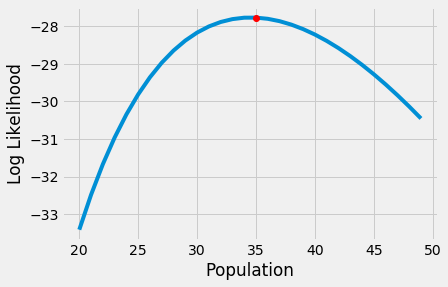

In [11]:
max_likes=[-1*x for x in likes] # convert back to positive log likelihood.
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL[19:49],max_likes[19:49])
    ax.plot(LL[max_likes.index(max(max_likes))], max(max_likes), 'ro')
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Population")

Ne=LL[max_likes.index(max(max_likes))]
print(Ne)

write_to_summary("Diffusion model (6) Ne:",Ne)

### Save output for plots

In [12]:
out_LL =[]
for i in range(0,len(LL)):
        out_LL.append({"Ne":LL[i],"LL":max_likes[i]})
out_pd = pd.DataFrame(out_LL)

out_pd.to_csv("../data/processed/secondary/intrahost_change_in_freq.LL.csv")

In [13]:
cutoff=max(max_likes)-1.92


In [14]:
above_cut=[x for x in max_likes if x >cutoff ]

The 95% confidence interval is 

In [15]:
CI = [LL[max_likes.index(above_cut[0])],LL[max_likes.index(above_cut[-1])]] # get the first and last Ne sizes in the CI range

write_to_summary("Diffusion model (6) CI:",CI)

In [16]:
LL12 = np.arange(1,50,1) # These are the effective population sizes
likes12 = []
for d in LL12:
    print( 'working with: '+ str(d))
    likes12.append(likelihood(d,intra_minor,12,acc_stringent))

working with: 1
working with: 2
working with: 3
working with: 4
working with: 5
working with: 6
working with: 7
working with: 8
working with: 9
working with: 10
working with: 11
working with: 12
working with: 13
working with: 14
working with: 15
working with: 16
working with: 17
working with: 18
working with: 19
working with: 20
working with: 21
working with: 22
working with: 23
working with: 24
working with: 25
working with: 26
working with: 27
working with: 28
working with: 29
working with: 30
working with: 31
working with: 32
working with: 33
working with: 34
working with: 35
working with: 36
working with: 37
working with: 38
working with: 39
working with: 40
working with: 41
working with: 42
working with: 43
working with: 44
working with: 45
working with: 46
working with: 47
working with: 48
working with: 49


17


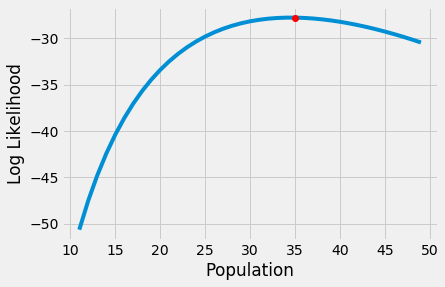

In [17]:
max_likes12=[-1*x for x in likes12] # convert back to positive log likelihood.
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL[10:49],max_likes[10:49])
    ax.plot(LL[max_likes.index(max(max_likes))], max(max_likes), 'ro')
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Population")

Ne=LL[max_likes12.index(max(max_likes12))]
print(Ne)
write_to_summary("Diffusion model (12) Ne:",Ne)


In [18]:
cutoff=max(max_likes12)-1.92

above_cut=[x for x in max_likes12 if x >cutoff ]

In [19]:
CI =[LL[max_likes12.index(above_cut[0])],LL[max_likes12.index(above_cut[-1])]] # get the first and last Ne sizes in the CI range
write_to_summary("Diffusion model (12) CI:",CI)

# Looking at Nonsynonymous and Synonymous mutations

## Nonsynonymous first

In [20]:
intra_nonsynon = intra_minor.loc[intra_minor.donor_class=="Nonsynonymous",]

LL = np.arange(1,50,1) # These are the effective population sizes
likes_nonsynom = []
for d in LL:
    print( 'working with: '+ str(d))
    likes_nonsynom.append(likelihood(d,intra_nonsynon,6,acc_stringent))

working with: 1
working with: 2
working with: 3
working with: 4
working with: 5
working with: 6
working with: 7
working with: 8
working with: 9
working with: 10
working with: 11
working with: 12
working with: 13
working with: 14
working with: 15
working with: 16
working with: 17
working with: 18
working with: 19
working with: 20
working with: 21
working with: 22
working with: 23
working with: 24
working with: 25
working with: 26
working with: 27
working with: 28
working with: 29
working with: 30
working with: 31
working with: 32
working with: 33
working with: 34
working with: 35
working with: 36
working with: 37
working with: 38
working with: 39
working with: 40
working with: 41
working with: 42
working with: 43
working with: 44
working with: 45
working with: 46
working with: 47
working with: 48
working with: 49


27


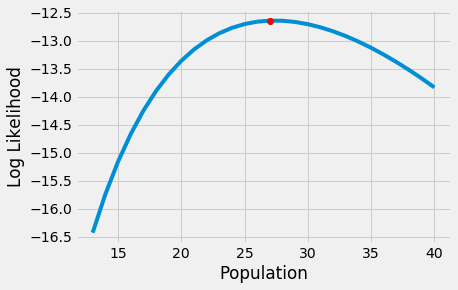

In [21]:
max_likes_nonsynom=[-1*x for x in likes_nonsynom]
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL[12:40],max_likes_nonsynom[12:40])
    ax.plot(LL[max_likes_nonsynom.index(max(max_likes_nonsynom))], max(max_likes_nonsynom), 'ro')
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Population")

Ne=LL[max_likes_nonsynom.index(max(max_likes_nonsynom))]
print(Ne)

## Synonymous

In [22]:
intra_synon = intra_minor.loc[intra_minor.donor_class=="Synonymous",]

LL = np.arange(1,50,1) # These are the effective population sizes
likes_synom = []
for d in LL:
    print( 'working with: '+ str(d))
    likes_synom.append(likelihood(d,intra_synon,6,acc_stringent))

working with: 1
working with: 2
working with: 3
working with: 4
working with: 5
working with: 6
working with: 7
working with: 8
working with: 9
working with: 10
working with: 11
working with: 12
working with: 13
working with: 14
working with: 15
working with: 16
working with: 17
working with: 18
working with: 19
working with: 20
working with: 21
working with: 22
working with: 23
working with: 24
working with: 25
working with: 26
working with: 27
working with: 28
working with: 29
working with: 30
working with: 31
working with: 32
working with: 33
working with: 34
working with: 35
working with: 36
working with: 37
working with: 38
working with: 39
working with: 40
working with: 41
working with: 42
working with: 43
working with: 44
working with: 45
working with: 46
working with: 47
working with: 48
working with: 49


40


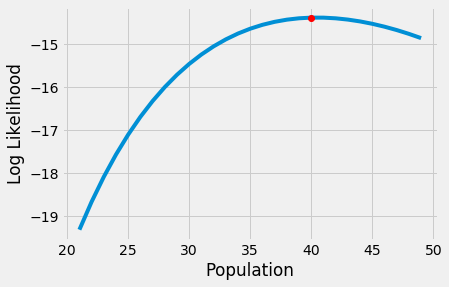

In [23]:
max_likes_nsynon=[-1*x for x in likes_synom]
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL[20:49],max_likes_nsynon[20:49])
    ax.plot(LL[max_likes_nsynon.index(max(max_likes_nsynon))], max(max_likes_nsynon), 'ro')
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Population")

Ne=LL[max_likes_nsynon.index(max(max_likes_nsynon))]
print(Ne)

# Comparision of All, Nonsynonymous and Synonymous fits

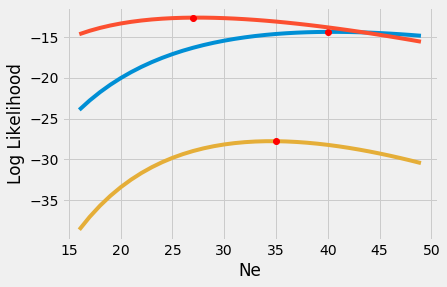

In [24]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL[15:49],max_likes_nsynon[15:49])
    ax.plot(LL[max_likes_nsynon.index(max(max_likes_nsynon))], max(max_likes_nsynon), 'ro')
    
    ax.plot(LL[15:49],max_likes_nonsynom[15:49])
    ax.plot(LL[max_likes_nonsynom.index(max(max_likes_nonsynom))], max(max_likes_nonsynom), 'ro')
    
    ax.plot(LL[15:49],max_likes[15:49])
    ax.plot(LL[max_likes.index(max(max_likes))], max(max_likes), 'ro')
    
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Ne")



# Sensitivity to outliers



In [25]:
intra_minor["delta"] = np.abs(intra_minor["freq1"] - intra_minor["freq2"]) / intra_minor["within_host_time"] # So the most extreme is on top of the order
minorOrdered = intra_minor.sort_values("delta",ascending=False)
minorOrdered

,Unnamed: 0,chr,pos,SPECID1,SPECID2,HOUSE_ID,ENROLLID,onset,collect1,collect2,...,mutation,ref,var,season,pcr_result,freq1,freq2,within_host_time,donor_class,delta
80,81,NS,538,HS1390,MH7852,5341,51438,2014-12-07,2014-12-07,2014-12-08,...,NS_T538C,T,C,2014-2015,A/H3N2,0.048701,0.487579,1,Nonsynonymous,0.438878
71,72,NR,501,HS1381,MH7800,5204,50874,2014-12-05,2014-12-05,2014-12-06,...,NR_A501G,A,G,2014-2015,A/H3N2,0.033171,0.467637,1,Nonsynonymous,0.434467
18,19,HA,524,HS1390,MH7852,5341,51438,2014-12-07,2014-12-07,2014-12-08,...,HA_T524C,T,C,2014-2015,A/H3N2,0.058846,0.489385,1,Synonymous,0.430539
123,124,PB1,1798,HS1381,MH7800,5204,50874,2014-12-05,2014-12-05,2014-12-06,...,PB1_G1798G,G,G,2014-2015,A/H3N2,0.178817,0.443234,1,Synonymous,0.264417
132,133,PB1,530,HS1381,MH7800,5204,50874,2014-12-05,2014-12-05,2014-12-06,...,PB1_G530A,G,A,2014-2015,A/H3N2,0.253518,0.473360,1,Nonsynonymous,0.219842
128,129,PB1,430,HS1390,MH7852,5341,51438,2014-12-07,2014-12-07,2014-12-08,...,PB1_G430A,G,A,2014-2015,A/H3N2,0.220773,0.039649,1,Synonymous,0.181124
22,23,HA,638,HS1390,MH7852,5341,51438,2014-12-07,2014-12-07,2014-12-08,...,HA_G638A,G,A,2014-2015,A/H3N2,0.213904,0.035977,1,Synonymous,0.177927
152,153,PB2,212,HS1381,MH7800,5204,50874,2014-12-05,2014-12-05,2014-12-06,...,PB2_G212A,G,A,2014-2015,A/H3N2,0.302404,0.470122,1,Nonsynonymous,0.167717
119,120,PB1,1705,HS1381,MH7800,5204,50874,2014-12-05,2014-12-05,2014-12-06,...,PB1_A1705G,A,G,2014-2015,A/H3N2,0.296343,0.461351,1,Synonymous,0.165008
136,137,PB1,910,HS1505,MH8391,5254,51073,2014-12-20,2014-12-20,2014-12-22,...,PB1_T910A,T,A,2014-2015,A/H3N2,0.340472,0.042143,2,Synonymous,0.149165


In [26]:
def MLfit(df,minN,maxN,acc=acc_stringent):
    LL = np.arange(minN,maxN,1) # These are the effective population sizes
    likes = []
    for d in LL:
        #print( 'working with: '+ str(d))
        likes.append(likelihood(d,df,6,acc))
        
    max_likes=[-1*x for x in likes]  
    Ne=LL[max_likes.index(max(max_likes))]
    return(Ne)

In [27]:
#Ne = []
#maxN = 70
#minN = 1
#len_isnv = len(minorOrdered)
#for i in range(0,26):
#    if maxN>300:
#        break
#    
#    Ne.append(MLfit(minorOrdered.iloc[i:len_isnv,],minN,maxN))
#    if maxN==Nₑ[i]:
#        while maxN==Nₑ[i]:
#            maxN +=50
#            minN +=50
#            if maxN>300:
#                break
#        
#            Ne.append(MLfit(minorOrdered.iloc[i:len_isnv,],minN,maxN))
#    print(i)



KeyboardInterrupt: 

In [ ]:
#Ne

# Looking at number of terms needed for infinite sums

Above we used 50. Do the outcomes change if we use 25 or 100

## 25


In [28]:
def non_fixed(p,x,t,N,sensitivity=False,*args,**kwargs):
    gc_ul = kwargs.get('gc_ul', None) # If these  variables are supplied get them. They are used to account for sensitivity. sensivity must be set to True
    acc = kwargs.get('acc', None)
    ith=[ith_term(i=1,p=p,x=x,t=t,N=N),ith_term(i=2,p=p,x=x,t=t,N=N)] # The first 2 terms are done to begin
    i = 3
#    while (ith[i-3]-ith[i-2])>1e-5: # Continue until the difference between the last 2 terms is less than 1e-5
#    while ith[i-2]>1e-3: 
    while i<=25:
        ith.append(ith_term(i=i,p=p,x=x,t=t,N=N))
        i+=1
    #print(ith)
    perfect_detect = np.sum(ith)


    if sensitivity == False :
        return(perfect_detect)
    
    else:# this is the probability of the variant being found where it was given the sensitivity. 
            # This is not used in the fitting of the model. All of these variants are found. For each N that we try this term doesn't change. So it is a constant not dependent on N and so doesn't affect the estimate.
            # It is useful though in getting a pdf that sums to 1 in the plots. If we don't have perfect sensitivity for the lost variants then we should treat these the same.
        acc_gc=10**(np.floor(np.log10(gc_ul)))
        if acc_gc>1e5: # set for the max
            acc_gc=1e5


        if x<0.05 and x>0.02:
            sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==0.02),'sensitivity']
            sense = sense.iloc[0]
            prob_detect = perfect_detect*sense
        elif x<0.1 and x>0.05:
            sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==0.05),'sensitivity']
            sense = sense.iloc[0]
            prob_detect = perfect_detect*sense
        else :
            prob_detect = perfect_detect

        return(prob_detect) 
def boundaries(p,t,N,final,gc_ul=1e5,sensitivity=False,*args,**kwargs):
    acc = kwargs.get('acc', None)
    
    #if final !=0 or final !=1:
    #    raise(ValueError,"Please select 0 or 1 as final frequency")
    if final==0:
        fixed_freq=1-p   # set for loss. The probabilty the other allele is fixed
    elif final ==1:
        fixed_freq = p

    ith=[ith_term_fixed(i=1,p=fixed_freq,t=t,N=N),ith_term_fixed(i=2,p=fixed_freq,t=t,N=N)] # The first 2 terms are done to begin 
    i = 3
#    while (ith[i-3]-ith[i-2])>1e-5: # Continue until the difference between the last 2 terms is less than 1e-5
#    while ith[i-2]>1e-3: 
    while i<=25:
        ith.append(ith_term_fixed(i=i,p=fixed_freq,t=t,N=N))
        i+=1
    fixed = fixed_freq+np.sum(ith)
    #print(fixed)
    if sensitivity == False:
            return(fixed)

        
    elif sensitivity == True:
        if final ==0 : 
            lost_p = p
        elif final==1:
            lost_p = 1-p
        below_threshold = below_cut(p=lost_p,t=t,N=N)
        missed= just_missed(p=lost_p,t=t,N=N,gc_ul=gc_ul,acc=acc)
        lost = below_threshold+missed
        return(lost+fixed)

In [29]:
LL = np.arange(1,50,1)
likes_25 = []
for d in LL:
    print( 'working with: '+ str(d))
    likes_25.append(likelihood(d,intra_minor,6,acc_stringent))


working with: 1
working with: 2
working with: 3
working with: 4
working with: 5
working with: 6
working with: 7
working with: 8
working with: 9
working with: 10
working with: 11
working with: 12
working with: 13
working with: 14
working with: 15
working with: 16
working with: 17
working with: 18
working with: 19
working with: 20
working with: 21
working with: 22
working with: 23
working with: 24
working with: 25
working with: 26
working with: 27
working with: 28
working with: 29
working with: 30
working with: 31
working with: 32
working with: 33
working with: 34
working with: 35
working with: 36
working with: 37
working with: 38
working with: 39
working with: 40
working with: 41
working with: 42
working with: 43
working with: 44
working with: 45
working with: 46
working with: 47
working with: 48
working with: 49


35


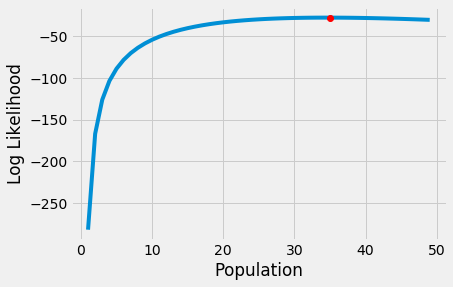

In [30]:
max_likes_25=[-1*x for x in likes_25]
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL,max_likes_25)
    ax.plot(LL[max_likes_25.index(max(max_likes_25))], max(max_likes_25), 'ro')
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Population")

Ne=LL[max_likes_25.index(max(max_likes_25))]
print(Ne)

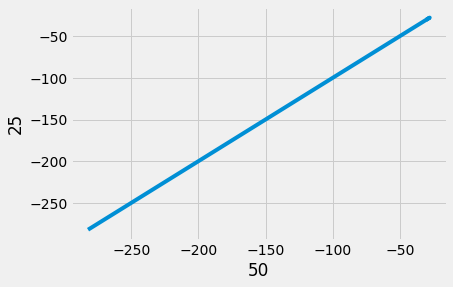

In [31]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(max_likes,max_likes_25)
    ax.set_ylabel("25")
    ax.set_xlabel("50")

In [32]:
[max_likes[i]-max_likes_25[i] for i in range(0,len(max_likes))]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -3.5527136788005009e-15,
 -3.5527136788005009e-15,
 -3.5527136788005009e-15,
 -3.5527136788005009e-15,
 7.1054273576010019e-15,
 1.0658141036401503e-14,
 -7.1054273576010019e-15,
 -2.8421709430404007e-14,
 2.8421709430404007e-14,
 1.6697754290362354e-13,
 3.5527136788005009e-13,
 9.8410168902773876e-13,
 2.7817748105007922e-12,
 6.9242389599821763e-12,
 1.6488144183313125e-11,
 3.8514968991876231e-11]

## 100

In [33]:
def non_fixed(p,x,t,N,sensitivity=False,*args,**kwargs):
    gc_ul = kwargs.get('gc_ul', None) # If these  variables are supplied get them. They are used to account for sensitivity. sensivity must be set to True
    acc = kwargs.get('acc', None)
    ith=[ith_term(i=1,p=p,x=x,t=t,N=N),ith_term(i=2,p=p,x=x,t=t,N=N)] # The first 2 terms are done to begin
    i = 3
#    while (ith[i-3]-ith[i-2])>1e-5: # Continue until the difference between the last 2 terms is less than 1e-5
#    while ith[i-2]>1e-3: 
    while i<=100:
        ith.append(ith_term(i=i,p=p,x=x,t=t,N=N))
        i+=1
    #print(ith)
    perfect_detect = np.sum(ith)


    if sensitivity == False :
        return(perfect_detect)
    
    else:# this is the probability of the variant being found where it was given the sensitivity. 
            # This is not used in the fitting of the model. All of these variants are found. For each N that we try this term doesn't change. So it is a constant not dependent on N and so doesn't affect the estimate.
            # It is useful though in getting a pdf that sums to 1 in the plots. If we don't have perfect sensitivity for the lost variants then we should treat these the same.
        acc_gc=10**(np.floor(np.log10(gc_ul)))
        if acc_gc>1e5: # set for the max
            acc_gc=1e5


        if x<0.05 and x>0.02:
            sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==0.02),'sensitivity']
            sense = sense.iloc[0]
            prob_detect = perfect_detect*sense
        elif x<0.1 and x>0.05:
            sense=acc.loc[(acc.gc_ul==acc_gc) & (acc.freq==0.05),'sensitivity']
            sense = sense.iloc[0]
            prob_detect = perfect_detect*sense
        else :
            prob_detect = perfect_detect

        return(prob_detect) 
def boundaries(p,t,N,final,gc_ul=1e5,sensitivity=False,*args,**kwargs):
    acc = kwargs.get('acc', None)
    
    #if final !=0 or final !=1:
    #    raise(ValueError,"Please select 0 or 1 as final frequency")
    if final==0:
        fixed_freq=1-p   # set for loss. The probabilty the other allele is fixed
    elif final ==1:
        fixed_freq = p

    ith=[ith_term_fixed(i=1,p=fixed_freq,t=t,N=N),ith_term_fixed(i=2,p=fixed_freq,t=t,N=N)] # The first 2 terms are done to begin 
    i = 3
#    while (ith[i-3]-ith[i-2])>1e-5: # Continue until the difference between the last 2 terms is less than 1e-5
#    while ith[i-2]>1e-3: 
    while i<=100:
        ith.append(ith_term_fixed(i=i,p=fixed_freq,t=t,N=N))
        i+=1
    fixed = fixed_freq+np.sum(ith)
    #print(fixed)
    if sensitivity == False:
            return(fixed)

        
    elif sensitivity == True:
        if final ==0 : 
            lost_p = p
        elif final==1:
            lost_p = 1-p
        below_threshold = below_cut(p=lost_p,t=t,N=N)
        missed= just_missed(p=lost_p,t=t,N=N,gc_ul=gc_ul,acc=acc)
        lost = below_threshold+missed
        return(lost+fixed)

In [34]:
LL = np.arange(1,50,1)
likes_100 = []
for d in LL:
    print( 'working with: '+ str(d))
    likes_100.append(likelihood(d,intra_minor,6,acc_stringent))

working with: 1
working with: 2
working with: 3
working with: 4
working with: 5
working with: 6
working with: 7
working with: 8
working with: 9
working with: 10
working with: 11
working with: 12
working with: 13
working with: 14
working with: 15
working with: 16
working with: 17
working with: 18
working with: 19
working with: 20
working with: 21
working with: 22
working with: 23
working with: 24
working with: 25
working with: 26
working with: 27
working with: 28
working with: 29
working with: 30
working with: 31
working with: 32
working with: 33
working with: 34
working with: 35
working with: 36
working with: 37
working with: 38
working with: 39
working with: 40
working with: 41
working with: 42
working with: 43
working with: 44
working with: 45
working with: 46
working with: 47
working with: 48
working with: 49


35


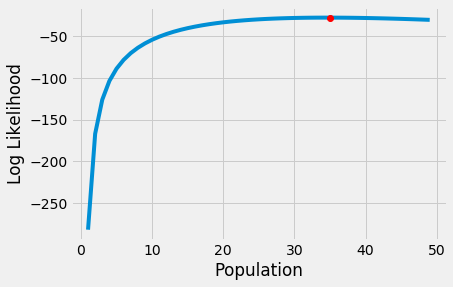

In [35]:
max_likes_100=[-1*x for x in likes_100]
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(LL,max_likes_100)
    ax.plot(LL[max_likes_100.index(max(max_likes_100))], max(max_likes_100), 'ro')
    ax.set_ylabel("Log Likelihood")
    ax.set_xlabel("Population")

Ne=LL[max_likes_100.index(max(max_likes_100))]
print(Ne)

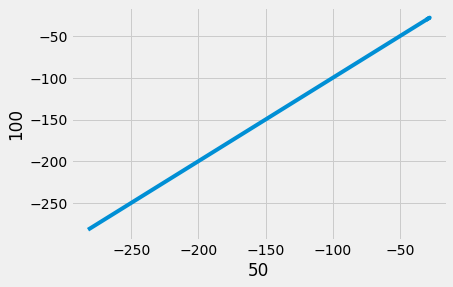

In [36]:
with plt.style.context('fivethirtyeight'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(max_likes,max_likes_100)
    ax.set_ylabel("100")
    ax.set_xlabel("50")

In [37]:
[max_likes[i]-max_likes_100[i] for i in range(0,len(max_likes))]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [38]:
def min_diff(data_list):
    out_list = [np.abs(data_list[i]-data_list[i+1]) for i in range(0,(len(data_list)-1))]
    return(min(out_list))
                                                           

In [39]:
print("25:%f\n50:%f\n100:%f" %(min_diff(max_likes_25),min_diff(max_likes),min_diff(max_likes_100)))

25:0.001891
50:0.001891
100:0.001891


In [40]:
x=boundaries(p=0.5,t=100,N=30,final=1,sensitivity = True,gc_ul=1e5,acc=acc_stringent)
x

0.4760805878741452